In [1]:
import numpy as np
import pandas as pd
import utm
import math
import os
import sys
sys.path.append('./src')
import math
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt

import display_gm
import display_osm
import plot
import tools
import celltower as ctcrawler
from data_cleaning import noise, load

<h2>Data Process</h2>

In [17]:
file_2g = './jiading/data_2g.csv'
gongcan_2g = './jiading/2g_gongcan.csv'
db, towers = load_2g(file_2g, gongcan_2g, merge_tower=True, neighbor=True, with_rssi=False, radio_angle=False)
print 'len(db):', len(db)

<type 'dict'>
How many Cell Tower:  62
duplicated cell towers: [[0, 13], [14, 22, 25], [4, 11], [5, 16], [19, 20], [3, 10, 24], [1, 7, 23]]
len(db): 25


<h2>Missed Traj ID</h2>

In [8]:
mmr = reload(mmr)
road_network = './Shanghai/SH_map'
sequences = dbs
alg_name = 'HMM'
search_radius = 50
time_gap = 5
max_route_distance = 2000000

start = time.time()
paths = mmr.map_match(road_network, sequences, search_radius,time_gap, max_route_distance)
end = time.time()
print 'Total cost:', (end - start), 's'

Total cost: 6.56100010872 s


num of obsv:  174
1 93
2 36
3 15
4 11
5 4
6 6
7 2
9 2
10 2
11 1
12 2


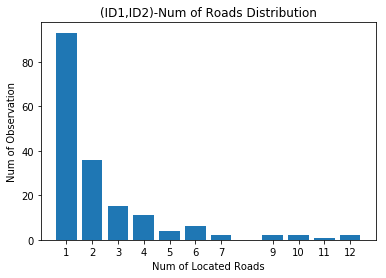

In [19]:
def find_matches_with(tr_id, idx, paths):
    for s, e, rid in paths[tr_id]:
        if s <= idx <= e:
            return rid
    return -1

O = dict()
summary = defaultdict(int)
obsv_set = set()
for tr_id, points in dbs.iteritems():
    for idx, point in enumerate(points):
        lat, lng, id1, id2 = point[:4]
        obsv = (id1, id2)
        obsv_set.add(obsv)
        rid = find_matches_with(tr_id, idx, paths)
        if obsv not in O.keys():
            O[obsv] = dict()
        if rid not in O[obsv].keys():
            O[obsv][rid] = 0
        O[obsv][rid] += 1

print 'num of obsv: ', len(obsv_set)
for obsv in O.iterkeys():
    num = len(O[obsv])
    summary[num] += 1

for num, val in summary.iteritems():
    print num, val
plt.bar(summary.keys(), height=summary.values())
xticks = [str(x) for x in summary.keys()]
plt.xticks(summary.keys(), xticks)
plt.title('(ID1,ID2)-Num of Roads Distribution')
plt.xlabel('Num of Located Roads')
plt.ylabel('Num of Observation')
plt.show()

In [ ]:
summary = []
for state in D.iterkeys():
    rid = sag.get_cid(state)
    to_time = sum(times for obsv, times in D[state].iteritems())
    to_obsv = len(D[state])
    summary.append((rid, to_obsv, to_time))
#     print 'Cell[%d] has %d obsv, with %d times...' % (cid, to_obsv, to_time)
df_freq = pd.DataFrame(summary, columns=['CellID', 'Obsv', 'Points'])
df_freq.describe()

<h2>Map Matching</h2>

In [ ]:
for i in range(len(dbs)):
    to_write = ''
    with open('./jiading/trajs/traj_%d.txt' % i, 'w') as fout:
        for lat, lng, _, _, ctime in dbs[i]:
            to_write += '%s,%s,%s\n' % (ctime, lat, lng)
        fout.write(to_write)

In [7]:
in_folder = './Shanghai/edgegeometry'
in_file = 'SH_EdgeGeometry.txt'
edges = dict()
with open(in_folder + '/' + in_file) as f:
    cnt = 0
    for line in f:
        nodes = []
        data = [float(d) for d in line.strip().split('^')[4:]]
        rid = int(line.strip().split('^')[0])
        lngs, lats = data[1::2], data[::2]
        edges[rid] = [(lat, lng) for lat, lng in zip(lats, lngs)]
        cnt += 1
print len(edges)

235


In [8]:
for i in range(len(dbs)):
    rids = []
    # (a, b, rid)
    path = []
    with open('./jiading/trajs/traj_%d.txt.HMM.G5.csv' % i) as fout:
        cnt = 0
        for line in fout:
            data = line.strip().split(',')
            if len(data)==1:
                continue
            rid = int(data[3])
            rids.append(rid)
            cnt += 1
    last_rid = 0
    last_idx = 0
    for idx in range(len(rids)):
        rid = rids[idx]
        if rid != last_rid and last_rid != 0:
            path.append((last_idx, idx - 1, last_rid))
            last_idx = idx
        last_rid = rid
    path.append((last_idx, len(rids) - 1, rid))
    ids = []
    for a, b, rid in path:
    #     print '[%d, %d]-rid %d' % (a, b, rid)
        ids.append(rid)
    print 'rid = %d:' % i
    print ids

rid = 0:
[164316039]
rid = 1:
[164316066, 164316057, 266157883, 164316030, 164316024, 164316065, 164316047, 263922901, 263922900, 263922899, 164316030, 164316039, 164316009, 266161866, 164316070, 164316010, 164316077, 164316016, 164316012, 164316031, 164316021, 164316057]
rid = 2:
[164316066, 164316021, 164316012, 164316056, 266345024, 164316011, 164316046, 164316014, 266157883, 135420817, 135420819, 384531666]
rid = 3:
[164316014, 266207478, 164316014, 384531665, 164316009, 266161866]
rid = 4:
[164316012, 164316031, 164316021, 164316057, 266157883, 164316030]
rid = 5:
[135419988, 135372842, 266221576]
rid = 6:
[263913994, 266207478, 266207479]
rid = 7:
[135419988, 135372842, 266221576, 164316030, 263913992]
rid = 8:
[164316014, 263913992]
rid = 9:
[263913994, 164316030, 266221576, 135372842, 384531666]
rid = 10:
[164316066, 135419988, 135382788, 135427149, 164316014]
rid = 11:
[164316057, 266157883]
rid = 12:
[266157883, 164316014, 384531665, 164316009, 266161866, 164316070, 164316010

<h2>Missed Cell Tower</h2>

In [4]:
load = reload(load)
dataset = 'jiading'
datatype = '2g'
data_file = './data/%s_%s/data_%s.csv' % (dataset, datatype, datatype)
gongcan_file = './data/%s_%s/gongcan_%s.csv' % (dataset, datatype, datatype)
disp_path = './display/%s_%s/' % (dataset, datatype)
data_path = './data/%s_%s/' % (dataset, datatype)

In [27]:
# df = pd.read_csv(data_file)
# print df.columns
# df = df.drop(['Unnamed: 0'], axis=1)
# print df.columns
# df.to_csv(data_file, index=False)

Index([u'Unnamed: 0', u'TrajID', u'IMEI', u'IMSI', u'MRTime', u'Longitude',
       u'Latitude', u'Altitude', u'Accuracy', u'Speed',
       ...
       u'RNCID_7', u'CellID_7', u'Arfcn_7', u'Basic_psc_pci_7', u'Lon_7',
       u'Lat_7', u'AsuLevel_7', u'SignalLevel_7', u'Dbm_7', u'Type_7'],
      dtype='object', length=108)
Index([u'TrajID', u'IMEI', u'IMSI', u'MRTime', u'Longitude', u'Latitude',
       u'Altitude', u'Accuracy', u'Speed', u'Dbm',
       ...
       u'RNCID_7', u'CellID_7', u'Arfcn_7', u'Basic_psc_pci_7', u'Lon_7',
       u'Lat_7', u'AsuLevel_7', u'SignalLevel_7', u'Dbm_7', u'Type_7'],
      dtype='object', length=107)


In [5]:
def valid_bs(rid, cid):
    return rid > 0 and cid > 0

df = pd.read_csv(data_file)
# o_towers = load.load_gongcan(gongcan_file)
o_towers = dict()
lost_cells = set()
valid_cnt = 0
for i, piece_data in df.iterrows():
    rid_1, cid_1, rssi_1, rid_2, cid_2, rssi_2, rid_3, cid_3, rssi_3, lat, lng, speed, tr_id, timestp = \
        piece_data['RNCID_1'], piece_data['CellID_1'], piece_data['Dbm_1'], \
        piece_data['RNCID_2'], piece_data['CellID_2'], piece_data['Dbm_2'], \
        piece_data['RNCID_3'], piece_data['CellID_3'], piece_data['Dbm_3'], \
        piece_data['Latitude'], piece_data['Longitude'], piece_data['Speed'], \
        int(piece_data['TrajID']), int(piece_data['MRTime']) / 1000
    if math.isnan(rid_1) or math.isnan(rid_2) or math.isnan(rid_3):
        print 'nan', i
        continue
#     if not (valid_bs(rid_1, cid_1) and valid_bs(rid_2, cid_2) and valid_bs(rid_3, cid_3)):
#         valid_cnt += 1
#         continue
    if (rid_1, cid_1) not in o_towers.keys() and valid_bs(rid_1, cid_1):
        lost_cells.add((rid_1, cid_1))
    if (rid_2, cid_2) not in o_towers.keys() and valid_bs(rid_2, cid_2):
        lost_cells.add((rid_2, cid_2))
    if (rid_3, cid_3) not in o_towers.keys() and valid_bs(rid_3, cid_3):
        lost_cells.add((rid_3, cid_3))
print valid_cnt

0


In [6]:
len(lost_cells)

111

In [7]:
lost_cells

{(5198.0, 1178.0),
 (5198L, 1186L),
 (5198.0, 1187.0),
 (5198L, 1188L),
 (5198L, 16057L),
 (5198L, 16058L),
 (5198.0, 16059.0),
 (5198.0, 16237.0),
 (5198.0, 16367.0),
 (5198.0, 16519.0),
 (5198.0, 17029.0),
 (5198.0, 17739.0),
 (5198.0, 20608.0),
 (5198.0, 20609.0),
 (5198.0, 23603.0),
 (5198.0, 25311.0),
 (5198.0, 25312.0),
 (5198.0, 32914.0),
 (5198.0, 36811.0),
 (5198.0, 38197.0),
 (5198.0, 38198.0),
 (5198.0, 41518.0),
 (5198.0, 42507.0),
 (5198L, 42508L),
 (5198.0, 42509.0),
 (5198.0, 42517.0),
 (5198L, 42518L),
 (5198L, 42519L),
 (5198L, 43857L),
 (5198.0, 43858.0),
 (5198.0, 44572.0),
 (5198.0, 46199.0),
 (5198.0, 49472.0),
 (5198.0, 49663.0),
 (5198.0, 49988.0),
 (5198.0, 49989.0),
 (5198L, 50807L),
 (5198L, 50809L),
 (5198.0, 56687.0),
 (5198.0, 56688.0),
 (5198.0, 56689.0),
 (5198.0, 57368.0),
 (5198L, 57857L),
 (5198.0, 64092.0),
 (5198.0, 64581.0),
 (5198.0, 64742.0),
 (6151.0, 14542.0),
 (6151L, 14547L),
 (6151.0, 14553.0),
 (6182L, 13394L),
 (6182.0, 13666.0),
 (6182.0, 

In [9]:
ctcrawler = reload(ctcrawler)
crawler = ctcrawler.CellTower()
result, failed = crawler.get_tower(lost_cells)

0
1
error:(6188,20897)
2
3
4
5
6
7
8
error:(6182,41139)
error:(6188,27393)
9
10
11
12
13
error:(6188,25763)
14
15
16
17
18
19
20
error:(6188,26049)
21
22
23
24
25
26
27
error:(6188,27378)
28
29
30
31
32
33
34
35
36
37
38
39
40
error:(6188,22673)
41
42
43
44
45
46
47
48
49
50
51
error:(6188,21329)
52
53
54
error:(6188,25089)
55
56
57
58
59
60
61
62
63
error:(6188,25105)
64
error:(6188,25859)
65
66
67
68
69
70
71
error:(6188,25187)
72
73
74
75
76
77
error:(6182,13394)
error:(6188,20865)
78
79
80
error:(6188,27361)
81
82
83
error:(6188,27314)
84
error:(6188,21331)
85
86
87
88
89
90
91
92
93


In [18]:
failed = failed[:1]

In [10]:
appendex, failed_ed = crawler.get_tower(failed)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


In [11]:
result.extend(appendex)

In [45]:
result = list(lost_cells)

In [13]:
new_towers = pd.DataFrame(result, columns=['RNCID', 'CellID', 'Latitude', 'Longitude', 'Azimuth', 'Downtilt'])
# old_towers = pd.read_csv(gongcan_file)[['RNCID', 'CellID']]
old_towers = pd.DataFrame()
total_towers = pd.concat([old_towers, new_towers]).sort_values(by=['RNCID', 'CellID']).reset_index(drop=True)
total_towers.to_csv(gongcan_file, index=False)

<h2>1.Particle Filtering</h2>

In [ ]:
hmm = reload(hmm)
predict_p = dict()
cnt = 0
for tr_id, traj in test.iteritems():
    obsv = traj[0][2:]
    N = len(D) * 4
    particles, init_rids = hmm.Particle.create_by_prior_dist(obsv, D, B_, N)
    try:
        result = hmm.particle_filter(traj, A, B_, particles, 100)
    except:
        print 'traj id:', tr_id, ' failed...'
        continue
    predict_p[tr_id] = result
    cnt += 1
    print 'traj id:', tr_id, ' success'
print 'success:', cnt